In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
def plot_series(time, series, start = 0, end= None, label = None):
    plt.plot(time[start:end], series[start:end], label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return time * slope

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2*np.pi), 1/np.exp(season_time * 3))

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase)%period)/period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed = None)
    return rnd.randn(len(time)) * noise_level

In [7]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

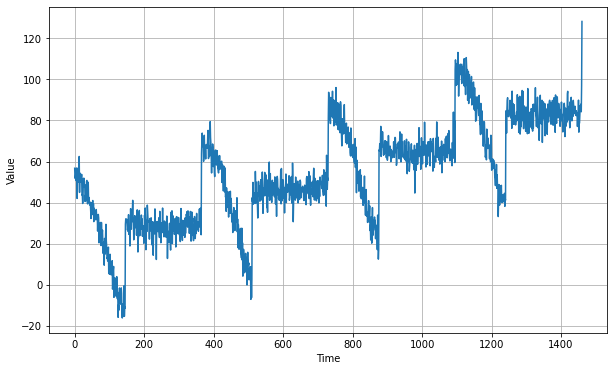

In [8]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [9]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Simple RNN Forecasting

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=-1),input_shape = [None]),
    tf.keras.layers.SimpleRNN(100, return_sequences = True),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200.0)
])

#learning Rate Schedule is basically used to get the best number for learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch/20))
model.compile(optimizer=tf.keras.optimizers.SGD(lr = 1e-7, momentum = 0.9), loss=tf.keras.losses.Huber(), metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

C:\Users\Mustafa Hasnain\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
45/45 [==============================] - 2s 16ms/step - loss: 21.3828 - mae: 21.8747
Epoch 2/100
45/45 [==============================] - 1s 15ms/step - loss: 11.7859 - mae: 12.2717
Epoch 3/100
45/45 [==============================] - 1s 16ms/step - loss: 11.2722 - mae: 11.7587
Epoch 4/100
45/45 [==============================] - 1s 18ms/step - loss: 10.9002 - mae: 11.3889
Epoch 5/100
45/45 [==============================] - 1s 14ms/step - loss: 10.2877 - mae: 10.7696
Epoch 6/100
45/45 [==============================] - 1s 15ms/step - loss: 9.9593 - mae: 10.4450A: 0s - loss: 9.8811 -
Epoch 7/100
45/45 [==============================] - 1s 16ms/step - loss: 9.6751 - mae: 10.1594
Epoch 8/100
45/45 [==============================] - 1s 15ms/step - loss: 9.3934 - mae: 9.8813
Epoch 9/100
45/45 [==============================] - 1s 14ms/step - loss: 9.1677 - mae: 9.6500
Epoch 10/100
45/45 [==============================] - 1s 15ms/step - loss: 8.9726 - mae: 9.4570
Epoch 11/100
45

45/45 [==============================] - 1s 15ms/step - loss: 5835.8042 - mae: 5836.3042
Epoch 85/100
45/45 [==============================] - 1s 15ms/step - loss: 6640.3188 - mae: 6640.8188
Epoch 86/100
45/45 [==============================] - 1s 15ms/step - loss: 9433.3252 - mae: 9433.8242: 0s - loss: 9250.3770 - mae: 9250.877
Epoch 87/100
45/45 [==============================] - 1s 15ms/step - loss: 7639.7217 - mae: 7640.2222
Epoch 88/100
45/45 [==============================] - 1s 15ms/step - loss: 11042.3301 - mae: 11042.8311
Epoch 89/100
45/45 [==============================] - 1s 14ms/step - loss: 5386.7339 - mae: 5387.2339
Epoch 90/100
45/45 [==============================] - 1s 14ms/step - loss: 7178.4590 - mae: 7178.9595
Epoch 91/100
45/45 [==============================] - 1s 14ms/step - loss: 12214.3535 - mae: 12214.8535
Epoch 92/100
45/45 [==============================] - 1s 15ms/step - loss: 11159.9844 - mae: 11160.4844
Epoch 93/100
45/45 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

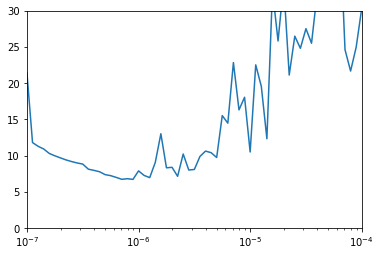

In [13]:
#Here we can visualize where the learnig rate is smooth and where it is not
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(100, return_sequences=True),
  tf.keras.layers.SimpleRNN(100),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = tf.keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 98ms/step - loss: 52.7371 - mae: 53.2346 - val_loss: 55.6942 - val_mae: 56.1942
INFO:tensorflow:Assets written to: my_checkpoint\assets
Epoch 2/500
8/8 [==============================] - 1s 60ms/step - loss: 34.1293 - mae: 34.6274 - val_loss: 20.4838 - val_mae: 20.9808
INFO:tensorflow:Assets written to: my_checkpoint\assets
Epoch 3/500
8/8 [==============================] - 1s 72ms/step - loss: 23.9950 - mae: 24.4915 - val_loss: 14.7050 - val_mae: 15.1998
INFO:tensorflow:Assets written to: my_checkpoint\assets
Epoch 4/500
8/8 [==============================] - 1s 66ms/step - loss: 17.7563 - mae: 18.2502 - val_loss: 24.0755 - val_mae: 24.5755
Epoch 5/500
8/8 [==============================] - 1s 61ms/step - loss: 15.1482 - mae: 15.6398 - val_loss: 9.4233 - val_mae: 9.9083
INFO:tensorflow:Assets written to: my_checkpoint\assets
Epoch 6/500
8/8 [==============================] - 1s 59ms/step - loss: 12.6790 - mae: 13.1678 - val_loss: 1

Epoch 58/500
8/8 [==============================] - 1s 73ms/step - loss: 5.5981 - mae: 6.0755 - val_loss: 5.9007 - val_mae: 6.3829
Epoch 59/500
8/8 [==============================] - 1s 61ms/step - loss: 5.4982 - mae: 5.9783 - val_loss: 6.3840 - val_mae: 6.8649
Epoch 60/500
8/8 [==============================] - 1s 61ms/step - loss: 5.5031 - mae: 5.9844 - val_loss: 7.0423 - val_mae: 7.5326
Epoch 61/500
8/8 [==============================] - 1s 58ms/step - loss: 5.6114 - mae: 6.0939 - val_loss: 9.0464 - val_mae: 9.5337
Epoch 62/500
8/8 [==============================] - 1s 59ms/step - loss: 5.7327 - mae: 6.2138 - val_loss: 5.5464 - val_mae: 6.0198
Epoch 63/500
8/8 [==============================] - 1s 60ms/step - loss: 5.5083 - mae: 5.9888 - val_loss: 5.2587 - val_mae: 5.7423
Epoch 64/500
8/8 [==============================] - 1s 58ms/step - loss: 5.9389 - mae: 6.4228 - val_loss: 6.4468 - val_mae: 6.9323
Epoch 65/500
8/8 [==============================] - 1s 58ms/step - loss: 6.4476 - m

Epoch 119/500
8/8 [==============================] - 1s 62ms/step - loss: 4.7705 - mae: 5.2456 - val_loss: 5.1813 - val_mae: 5.6600
Epoch 120/500
8/8 [==============================] - 1s 59ms/step - loss: 4.7021 - mae: 5.1846 - val_loss: 5.7515 - val_mae: 6.2315
Epoch 121/500
8/8 [==============================] - 1s 61ms/step - loss: 4.6090 - mae: 5.0853 - val_loss: 5.1296 - val_mae: 5.6041
Epoch 122/500
8/8 [==============================] - 1s 59ms/step - loss: 4.7980 - mae: 5.2743 - val_loss: 5.3495 - val_mae: 5.8261
Epoch 123/500
8/8 [==============================] - 1s 59ms/step - loss: 4.8895 - mae: 5.3645 - val_loss: 6.5813 - val_mae: 7.0697
Epoch 124/500
8/8 [==============================] - 1s 62ms/step - loss: 5.0015 - mae: 5.4784 - val_loss: 6.5438 - val_mae: 7.0321
Epoch 125/500
8/8 [==============================] - 1s 62ms/step - loss: 4.9889 - mae: 5.4707 - val_loss: 7.0030 - val_mae: 7.4875
Epoch 126/500
8/8 [==============================] - 1s 56ms/step - loss: 4.

In [20]:
model = tf.keras.models.load_model("my_checkpoint")

In [21]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

In [23]:
rnn_forecast.shape

(461,)

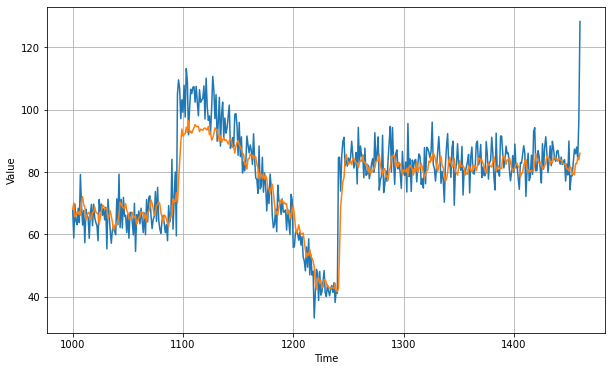

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.3857193

# Sequence-to-Sequence Forecasting

In [27]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [28]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  tf.keras.layers.SimpleRNN(100, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

C:\Users\Mustafa Hasnain\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/500
8/8 [==============================] - 2s 109ms/step - loss: 53.2106 - mae: 53.7087 - val_loss: 17.8107 - val_mae: 18.3048
Epoch 2/500
8/8 [==============================] - 1s 74ms/step - loss: 33.6590 - mae: 34.1558 - val_loss: 21.1700 - val_mae: 21.6657
Epoch 3/500
8/8 [==============================] - 1s 63ms/step - loss: 26.4812 - mae: 26.9763 - val_loss: 37.6553 - val_mae: 38.1548
Epoch 4/500
8/8 [==============================] - 1s 61ms/step - loss: 20.3886 - mae: 20.8818 - val_loss: 24.8600 - val_mae: 25.3591
Epoch 5/500
8/8 [==============================] - 1s 60ms/step - loss: 16.5261 - mae: 17.0158 - val_loss: 15.0220 - val_mae: 15.5165
Epoch 6/500
8/8 [==============================] - 1s 58ms/step - loss: 14.4510 - mae: 14.9376 - val_loss: 9.2049 - val_mae: 9.6894
Epoch 7/500
8/8 [==============================] - 1s 59ms/step - loss: 13.3629 - mae: 13.8481 - val_loss: 9.4013 - val_mae: 9.8881
Epoch 8/500
8/8 [==============================] - 1s 61ms/step -

8/8 [==============================] - 1s 62ms/step - loss: 6.1355 - mae: 6.6148 - val_loss: 6.0472 - val_mae: 6.5321
Epoch 64/500
8/8 [==============================] - 1s 58ms/step - loss: 6.1055 - mae: 6.5844 - val_loss: 6.1379 - val_mae: 6.6217
Epoch 65/500
8/8 [==============================] - 1s 57ms/step - loss: 6.0771 - mae: 6.5561 - val_loss: 6.0055 - val_mae: 6.4902
Epoch 66/500
8/8 [==============================] - 1s 60ms/step - loss: 6.0513 - mae: 6.5302 - val_loss: 6.0070 - val_mae: 6.4914
Epoch 67/500
8/8 [==============================] - 1s 60ms/step - loss: 6.0203 - mae: 6.4990 - val_loss: 6.0958 - val_mae: 6.5796
Epoch 68/500
8/8 [==============================] - 1s 60ms/step - loss: 5.9955 - mae: 6.4737 - val_loss: 5.9759 - val_mae: 6.4602
Epoch 69/500
8/8 [==============================] - 1s 60ms/step - loss: 5.9712 - mae: 6.4495 - val_loss: 6.0384 - val_mae: 6.5221
Epoch 70/500
8/8 [==============================] - 1s 57ms/step - loss: 5.9487 - mae: 6.4273 - 

In [31]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

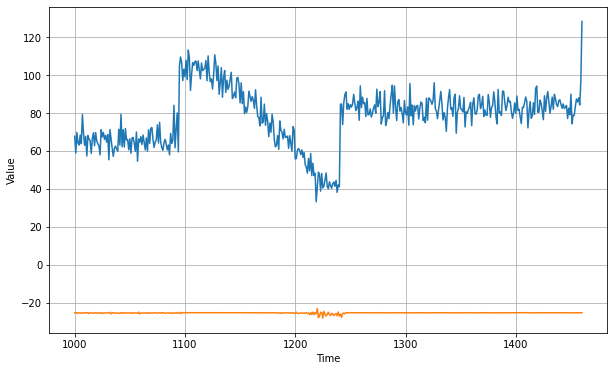

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

103.19254